# Part03 Algorithm Implementation, Model Training, and Performance Measurement

In [42]:
from __future__ import annotations

# import modules

from typing import List, Dict, Union
import time

import joblib
import pandas as pd
import numpy as np
import yaml
import shap as shp
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

from src.classes.NpData import NpData
from src.commons.Utils import impute_scale_and_convert_to_numpy

In [24]:
# read training dataset
ohe_train: pd.DataFrame = pd.read_csv(
    filepath_or_buffer="../../dataset/01_interim/ohe_train.csv"
)

churn_train: pd.DataFrame = pd.read_csv(
    filepath_or_buffer="../../dataset/01_interim/churn_train.csv"
)

ohe_val: pd.DataFrame = pd.read_csv(
    filepath_or_buffer="../../dataset/01_interim/ohe_val.csv"
)

churn_val: pd.DataFrame = pd.read_csv(
    filepath_or_buffer="../../dataset/01_interim/churn_val.csv"
)

ohe_test: pd.DataFrame = pd.read_csv(
    filepath_or_buffer="../../dataset/01_interim/ohe_test.csv"
)

churn_test: pd.DataFrame = pd.read_csv(
    filepath_or_buffer="../../dataset/01_interim/churn_test.csv"
)

In [25]:
with open(file="../../config.yaml", mode="r") as file_stream: 
    stream_loader = yaml.load(
        stream=file_stream,
        Loader=yaml.SafeLoader
    )
    mean_total_charges: float = stream_loader["MEAN_TOTAL_CHARGES"]

In [26]:
scaler_folder: str = f"../../models/scaler"

feature_train_np: np.ndarray
churn_train_np: np.ndarray

feature_val_np: np.ndarray
churn_val_np: np.ndarray

feature_test_np: np.ndarray
churn_test_np: np.ndarray

feature_train_np, churn_train_np = impute_scale_and_convert_to_numpy(
    ohe_df=ohe_train,
    columns_with_nulls=["TotalCharges"],
    impute_val=[mean_total_charges],
    scaler_folder=scaler_folder,
    churn_df=churn_train
)

feature_val_np, churn_val_np = impute_scale_and_convert_to_numpy(
    ohe_df=ohe_val,
    columns_with_nulls=["TotalCharges"],
    impute_val=[mean_total_charges],
    scaler_folder=scaler_folder,
    churn_df=churn_val    
)

feature_test_np, churn_test_np = impute_scale_and_convert_to_numpy(
    ohe_df=ohe_test,
    columns_with_nulls=["TotalCharges"],
    impute_val=[mean_total_charges],
    scaler_folder=scaler_folder,
    churn_df=churn_test    
)

Ok, so we have : 
 (1) imported all necessary modules
 (2) load train, validation, and test dataset
 (3) impute, scale, and convert the dataset to numpy

Now, we will subject all feature_** to PCA, so that we can get denser representation instead of a sparse matrix

In [27]:
# Load trained PCA
pca: PCA = joblib.load(
    filename="../../models/feature_pca.pkl",
)

feature_train_pca: np.ndarray = pca.transform(feature_train_np)
feature_val_pca: np.ndarray = pca.transform(feature_val_np)
feature_test_pca: np.ndarray = pca.transform(feature_test_np)

In [28]:
# initiate candidate models

# LogisticRegression is famous for being the simplest model for binary classification task such as churn prediction. 
# We can use LogisticRegression model as the base whose performance against which to compare other models
lr_classifier: LogisticRegression = LogisticRegression()

# RandomForestClassifier is a famous ensemble algorithm used for multi-class classification. It can handle binary classification as well
# The algorithm is an ensemble algorithm based on tree simple learners
# The algorithm make classification by taking a "voting" from all the trees trained
rf_classifier: RandomForestClassifier = RandomForestClassifier()

# GradientBoostingClassifier is another ensemble algorithm used for multi-class classification. 
# This algorithm too are based on tree simple learners
# In the GradientBoosting algorithm, however, the tree are arranged in sequence, whereby each sequence down the line try to rectify the error made upstream simple learner(s)
gb_classifier: GradientBoostingClassifier = GradientBoostingClassifier()

# Finally, SupportVectorMachine (SVM) classifier (SVC) is another algorithm that can be used for classification task
# This algorithm aims to "project" the data points to ever higher dimensions until a hyperplane can be found that separate the data points into classes
sv_classifier: SVC = SVC()


# We start all models with default hyperparameters

In [29]:
# Combining all these candidate models inside Object 
class TrainValTestPerformance(object):
    
    def __init__(
            self
    ) -> None:
        """
        Class to track how metrics in a model perform in training, validation, and testing
        """
        self.training_score: float = 0.0
        self.validation_score: float = 0.0
        self.testing_score: float = 0.0
    
class ModelCandidate(object):
    TRAIN: str = "train"
    VALIDATE: str = "validate"
    TEST: str = "test"
    def __init__(
            self,
            classification_model: Union[LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, SVC],
            n_class: int
    ) -> None:
        """
        Class to records things related to model performance. 
        The parameters included currently are
        * model complexity, as measured by training time. More complex model usually are longer to train
        * accuracy_score
        * f1_score
        * confusion_matrix
        
        :param classification_model: 
        :param n_class: 
        """
        self.classification_model: Union[LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, SVC] = classification_model
        self.confusion_matrix: np.ndarray = np.empty(shape=(n_class, n_class))
        self.training_time: float = 0.0 
        self.accuracy_score: TrainValTestPerformance = TrainValTestPerformance()
        self.f1_score: TrainValTestPerformance = TrainValTestPerformance()
    
    
    def save_trained_model(
            self, 
            trained_model: Union[LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, SVC]
    ) -> None:
        self.classification_model = trained_model
    
    
    def log_training_time(
            self, 
            training_time: float
    ) -> None:
        self.training_time = training_time
    
    def calculate_accuracy(
            self, 
            y_true: np.ndarray,
            y_pred: np.ndarray, 
            stage: str = "train"
    ) -> None:
        _acc_score: float = accuracy_score(y_true=y_true, y_pred=y_pred)
        
        if stage == ModelCandidate.TRAIN:
            self.accuracy_score.training_score = _acc_score
        
        if stage == ModelCandidate.VALIDATE:
            self.accuracy_score.validation_score = _acc_score
        
        if stage == ModelCandidate.TEST:
            self.accuracy_score.testing_score = _acc_score
    
    def calculate_confusion_matrix(
            self, 
            y_true: np.ndarray,
            y_pred: np.ndarray 
    ) -> None:
        self.confusion_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)
    
    def calculate_f1_score(
            self, 
            y_true: np.ndarray,
            y_pred: np.ndarray, 
            stage: str = "train"
    ) -> None:
        _f1_score: float = f1_score(y_true=y_true, y_pred=y_pred)
        
        if stage == ModelCandidate.TRAIN:
            self.f1_score.training_score = _f1_score
        
        if stage == ModelCandidate.VALIDATE: 
            self.f1_score.validation_score = _f1_score
        
        if stage == ModelCandidate.TEST:
            self.f1_score.testing_score = _f1_score
        

classifier_candidates: Dict[str, ModelCandidate] = {
    "lr_classifier": ModelCandidate(classification_model=lr_classifier, n_class=len(np.unique(churn_train_np))),
    "rf_classifier": ModelCandidate(classification_model=rf_classifier, n_class=len(np.unique(churn_train_np))),
    "gb_classifier": ModelCandidate(classification_model=gb_classifier, n_class=len(np.unique(churn_train_np))),
    "sv_classifier": ModelCandidate(classification_model=sv_classifier, n_class=len(np.unique(churn_train_np)))
}

for _, each_candidate in classifier_candidates.items():
    _tic: float = time.time()
    
    _classifier_model = each_candidate.classification_model
    _classifier_model.fit(
        X=feature_train_pca,
        y=churn_train_np.ravel()
    )
    
    each_candidate.save_trained_model(trained_model=_classifier_model)
    
    _toc: float = time.time()
    training_time: float = _toc - _tic
    each_candidate.log_training_time(training_time=training_time)
    
    # training performance
    y_pred: np.ndarray = _classifier_model.predict(X=feature_train_pca)
    each_candidate.calculate_accuracy(
        y_true=churn_train_np.ravel(),
        y_pred=y_pred, 
        stage=ModelCandidate.TRAIN
    )
    
    each_candidate.calculate_f1_score(
        y_true=churn_train_np.ravel(),
        y_pred=y_pred, 
        stage=ModelCandidate.TRAIN        
    )
    
    each_candidate.calculate_confusion_matrix(
        y_true=churn_train_np.ravel(),
        y_pred=y_pred        
    )
    
    # validation performance
    y_pred: np.ndarray = _classifier_model.predict(X=feature_val_pca)
    each_candidate.calculate_accuracy(
        y_true=churn_val_np.ravel(),
        y_pred=y_pred,
        stage=ModelCandidate.VALIDATE
    )
    
    each_candidate.calculate_f1_score(
        y_true=churn_val_np.ravel(),
        y_pred=y_pred,
        stage=ModelCandidate.VALIDATE        
    )
    
    each_candidate.calculate_confusion_matrix(
        y_true=churn_val_np.ravel(),
        y_pred=y_pred,        
    )
    
    # testing performance
    y_pred: np.ndarray = _classifier_model.predict(X=feature_test_pca)
    each_candidate.calculate_accuracy(
        y_true=churn_test_np.ravel(),
        y_pred=y_pred,
        stage=ModelCandidate.TEST
    )
    
    each_candidate.calculate_f1_score(
        y_true=churn_test_np.ravel(),
        y_pred=y_pred,
        stage=ModelCandidate.TEST        
    )
    
    each_candidate.calculate_confusion_matrix(
        y_true=churn_test_np.ravel(),
        y_pred=y_pred,        
    )
    

In [30]:
for each_name, each_candidate in classifier_candidates.items():
    
    print(f"{each_name} model")
    print(f"training time {each_candidate.training_time} seconds")
    print("\n")
    print(f"accuracy_training {each_candidate.accuracy_score.training_score}")
    print(f"accuracy_validation {each_candidate.accuracy_score.validation_score}")
    print(f"accuracy_testing {each_candidate.accuracy_score.testing_score}")
    print("\n")
    print(f"f1_score_training {each_candidate.f1_score.training_score}")
    print(f"f1_score_validation {each_candidate.f1_score.validation_score}")
    print(f"f1_score_testing {each_candidate.f1_score.testing_score}")
    print("\n")
    print("---"*10)

lr_classifier model
training time 0.009688138961791992 seconds


accuracy_training 0.7457912457912458
accuracy_validation 0.7420078519349411
accuracy_testing 0.7543466068424004


f1_score_training 0.6998011928429424
f1_score_validation 0.6904441453566622
f1_score_testing 0.7040540540540541


------------------------------
rf_classifier model
training time 0.9656319618225098 seconds


accuracy_training 0.9979423868312757
accuracy_validation 0.8014582164890633
accuracy_testing 0.8014582164890633


f1_score_training 0.9975517471622524
f1_score_validation 0.7801242236024845
f1_score_testing 0.7736572890025576


------------------------------
gb_classifier model
training time 0.9214780330657959 seconds


accuracy_training 0.7691732136176581
accuracy_validation 0.7453729669097028
accuracy_testing 0.7560291643297813


f1_score_training 0.7289103690685412
f1_score_validation 0.6997354497354497
f1_score_testing 0.7098065376917945


------------------------------
sv_classifier model
training tim

There are several intersting points to note from this simple experiment

1. `Logistic Regression` model, being the simplest models of all, have the shortest training time, and it already offers reasonable accuracy at ~ 0.7 throughout traiining, validation, and testing. Furthermore, comparing `accuracy_score` and `f1_score` across training, validation, and testing stages gives a hint that `Logistic Regression` - despite its simplicity - ca be generalized. That is, the model does not over fit. That said, `Logistic Regression` model have only few hyparparameter that can be tuned - and hence, it may be difficult to fine-tune the model further
2. `Random Forest Classifier` model have the best overall accuracy amongst all other models. The training time of `Random Forest Classifier` is about 10x slower than Logistic Regression, meaning it considerably more complex than Logistic Regression. This training time, however, is still relatively modest if compared to  `Support Vector Classifier` model. Comparing the accuracy and f1_score metrics in training, validation, and testing stage, however, reveals that `Random Forest Classifier` grossly over fit, and hence - as it is - will not be as usable if we feed new data to predict classification. `Random Forest Classifier` have many more hyperparameters that can be tuned compared to `Logistic Regression`, which means we may be able to reduce the over fitting problem by appropriately fine-tuning the model
3. `Gradient Boosting Classifier` take slightly longer to train compared to `Random Forest Classifier`. This is expected, given that the algorightm is using sequences of weak learners to rectify errors made from earlier weak learners. This longer training time, however, seems to be worth it, because comparing the metrics accuracy and f1_score across training, validation, and testing stages seems to indicate that the model is actually generalizable - and hence, should perform better compared to `Random Forest Classifier` when fed new data for classification task. Furthermore, we have not yet fine tune the model in this step, and as such the performance given is given out-of-the-box from the default settings from sci-kit learn. Hence, `Gradient Boosting Classifier` seems to give us a bright promise to fine tune further.
4. Finally, `Support Vactor Classifier` takes the longest time tom train. This is too expected given that the strategy taken with this algorithm is to project the data points to every higher dimension to search a hyperplane that can separate the data into appropriate class. This complexity, however, does not give us extra benefit, as can be seen from the accuracy and f1_score across training, validation, and testing stage. 


Hence, we will select `Gradient Boosting Classification` algorithm to base our hyperparameter tuning later. 

In [31]:
# Save Gradient Boosting Classifier Algorithm
gb_classifier: GradientBoostingClassifier = classifier_candidates["gb_classifier"].classification_model

file_name: str = "../../models/gb_classifier.pkl"

joblib.dump(
    value=gb_classifier,
    filename=file_name
)

['../../models/gb_classifier.pkl']

Before we move on tuning the Hyperparameter, however, usually it's a good idea to check the explainability of the model. so that we can understand the strength of each features driving the classification. 

Given that our raw data itself are not uniform, the explainability can give us clue on where to focus our investigation of bias later

To investigate the explainability of the model, we will be calculating SHAP value across all the features

PermutationExplainer explainer: 5347it [35:19,  2.51it/s]                          


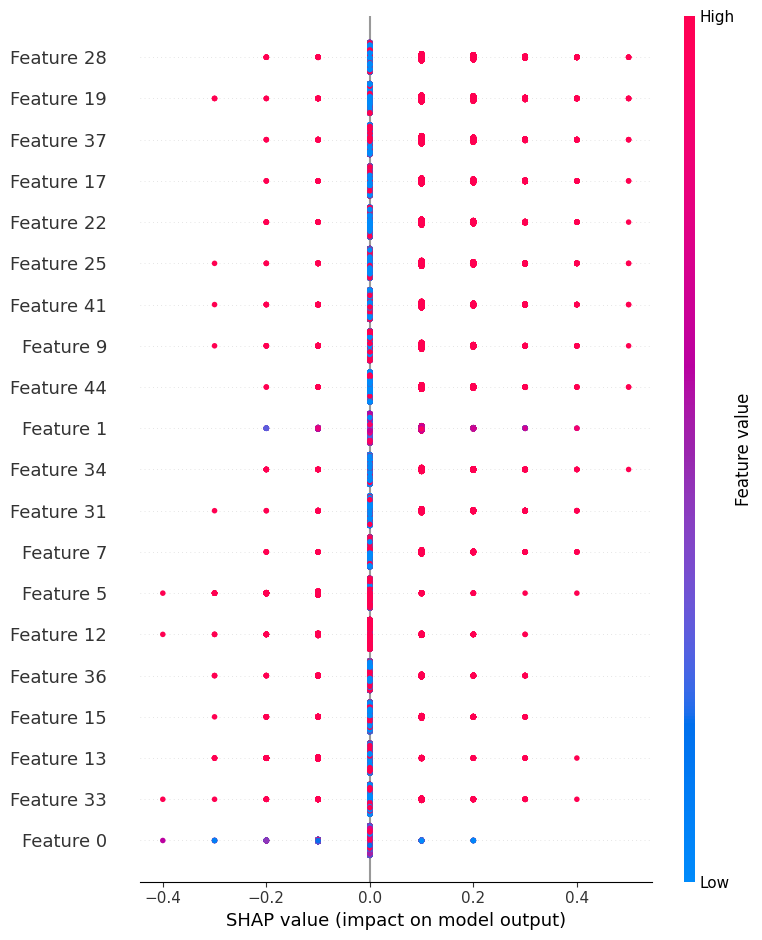

<Figure size 640x480 with 0 Axes>

In [43]:
# create masker for shap calculation
def my_masker(mask, x):
    # in this simple example we just zero out the features we are masking
    return (x * mask).reshape(1, len(x))

# create function to wrap the entire steps for predicting
def make_prediction(
        feature_np: np.ndarray
) -> None:
    
    pca: PCA = joblib.load(
        filename="../../models/feature_pca.pkl"
    )
    
    feature_pca: np.ndarray = pca.transform(X=feature_np)
    
    gb_classifier: GradientBoostingClassifier = joblib.load(
        filename="../../models/gb_classifier.pkl"
    )
    
    return gb_classifier.predict(X=feature_pca)


explainer: shp.Explainer = shp.Explainer(
    model=make_prediction,
    masker=my_masker
    
)

explainer_test: shp.Explainer = explainer(feature_train_np)
shp.summary_plot(explainer_test)

plt.savefig(
    "../figures/shap_value_explainer.png"
)

    

Of course, the above graph is still difficult to interpret, because we see "feature 0" etc, which we couldn't remember. 

We still need some map to translate the index back to meaningful name

In [50]:
feature_names: List[str] = ohe_train.columns.to_list()

for each_idx, feature_name in enumerate(feature_names):
    print(f"feature_{each_idx} is {feature_name}")

feature_0 is tenure
feature_1 is MonthlyCharges
feature_2 is TotalCharges
feature_3 is gender_Female
feature_4 is gender_Male
feature_5 is SeniorCitizen_0
feature_6 is SeniorCitizen_1
feature_7 is Partner_No
feature_8 is Partner_Yes
feature_9 is Dependents_No
feature_10 is Dependents_Yes
feature_11 is PhoneService_No
feature_12 is PhoneService_Yes
feature_13 is MultipleLines_No
feature_14 is MultipleLines_No phone service
feature_15 is MultipleLines_Yes
feature_16 is InternetService_DSL
feature_17 is InternetService_Fiber optic
feature_18 is InternetService_No
feature_19 is OnlineSecurity_No
feature_20 is OnlineSecurity_No internet service
feature_21 is OnlineSecurity_Yes
feature_22 is OnlineBackup_No
feature_23 is OnlineBackup_No internet service
feature_24 is OnlineBackup_Yes
feature_25 is DeviceProtection_No
feature_26 is DeviceProtection_No internet service
feature_27 is DeviceProtection_Yes
feature_28 is TechSupport_No
feature_29 is TechSupport_No internet service
feature_30 is Te